In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import trange

In [2]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 392)
        self.fc2 = nn.Linear(392, 100)
        self.fc3 = nn.Linear(100, 10)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [4]:
for epoch in ( t := trange(10)):
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    t.set_description('epoch: %d, loss: %.3f' % (epoch+1, running_loss/len(train_loader)))

epoch: 10, loss: 0.014: 100%|██████████| 10/10 [00:25<00:00,  2.59s/it]


In [5]:
# test
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted==labels).sum().item()
print('accuracy: %.3f' % (correct/total))

accuracy: 0.980


In [6]:
dummy_input = torch.randn(1, 1, 28, 28)  # Create a dummy input tensor
onnx_path = './docs/models/model.onnx'

torch.onnx.export(net, dummy_input, onnx_path)

================ Diagnostic Run torch.onnx.export version 2.0.1 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



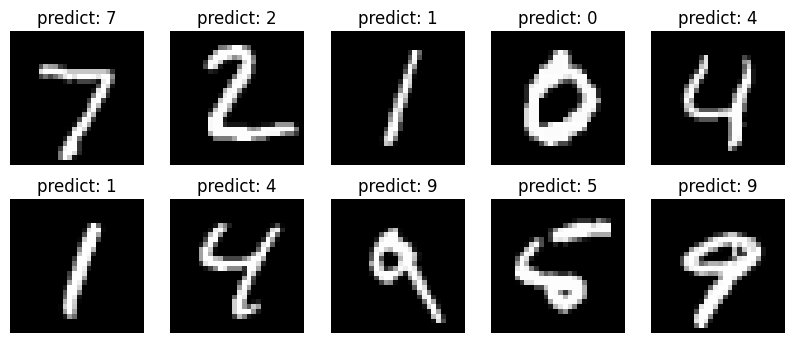

In [7]:
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        break

fig = plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(inputs[i][0], cmap='gray')
    plt.title('predict: %d' % predicted[i].item())
    plt.axis('off')